In [7]:
import requests
from io import BytesIO
from PIL import Image
import os

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

from DataHandlers import ImageDataset, InMemDataLoader

In [135]:
metadata = pd.read_csv('data/train.csv')

crop_size = 200

transform = T.Compose([
    T.Resize(200),
    T.CenterCrop(150),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageDataset(metadata, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 224, 224])


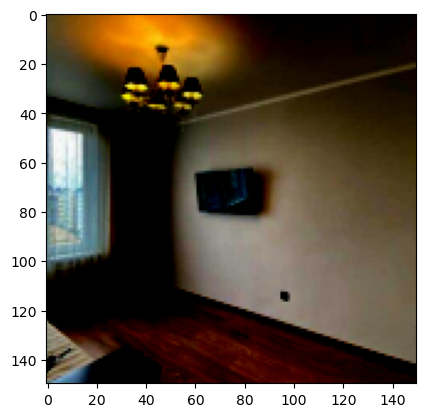

In [136]:
# Display example image
plt.imshow(dataset[np.random.randint(10)][1].numpy().transpose(1,2,0))
print(f'Image shape: {img.shape}')

In [137]:
loader = InMemDataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
   # sampler=None,
   # batch_sampler=None,
   # drop_last=False,
   # augment=False,
)

  0%|          | 0/4757 [00:00<?, ?it/s]

In [138]:
"""
    Naive solution - just taking the pixel difference of images
"""

deltas = torch.cat([batch[0] - batch[1] for batch in tqdm(loader)])
equals = torch.cat([batch[2] for batch in tqdm(loader)])

deltas.shape, equals.shape

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

(torch.Size([4757, 3, 150, 150]), torch.Size([4757]))

In [ ]:
from sklearn.linear_model import LogisticRegression

x_np = deltas.numpy()
y_np = equals.numpy()

x_np = x_np.reshape(len(dataset), -1)

print(f'x_np_2d.shape: {x_np.shape}')

model = LogisticRegression()
model.fit(x_np, y_np)

predictions = model.predict(x_np)

print(f'LogReg Accuracy: {(predictions == y_np).mean()}')
print(f'Random Accuracy: {(np.random.randint(2, size=(4757,)) == y_np).mean()}')

x_np_2d.shape: (4757, 67500)
